# Compare GBI index

Author: Ziqi Yin

Last modified: 2024 Feb 16

Table of contents:
* [Plot (a) GBI index time series for the whole 350 years; (b) scatter plot of JJA GBI and melt.](#first-bullet)

In [3]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.signal as sig # for filtering

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import geocat.comp as gc # to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
## Parameter
g = 9.80616 #[m/s2]
Rd = 287.0423 #[J/kg/K]
p0 = 1e5 #[Pa]

## 1. GBI series

### Read data

In [5]:
## BG iteration 7
BG7_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_Z3_JJA_yearly.nc')['Z3'] #geopotential height(asl) [m]
BG7_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PS_JJA_yearly.nc')['PS'] #surface pressure [Pa]
hyam = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hyam'] #hybrid A coefficient at layer midpoints [] 
hybm = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hybm'] #hybrid B coefficient at layer midpoints []
f09_lon = BG7_Z3_JJA_yearly.lon
f09_lat = BG7_Z3_JJA_yearly.lat

In [6]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_Z3_1pctCO2_JJA_yearly.nc')['Z3'][:140,:,:,:]
f09_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PS_1pctCO2_JJA_yearly.nc')['PS'][:140,:,:]

# 4xext
f09_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_Z3_4xext_JJA_yearly.nc')['Z3']
f09_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PS_4xext_JJA_yearly.nc')['PS']

In [7]:
## f09nohacks
# piControl
f09_nohacks_piControl_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_piControl_JJA_yearly.nc')['Z3']
f09_nohacks_piControl_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_piControl_JJA_yearly.nc')['PS']

# 1pctCO2
f09_nohacks_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_1pctCO2_JJA_yearly.nc')['Z3']
f09_nohacks_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_1pctCO2_JJA_yearly.nc')['PS']

# 4xext
f09_nohacks_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_4xext_JJA_yearly.nc')['Z3']
f09_nohacks_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_4xext_JJA_yearly.nc')['PS']

In [8]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_piControl_p4_JJA_yearly.nc')['Z3']
ARCTIC_piControl_p4_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_piControl_p4_JJA_yearly.nc')['PS']

# 1pctCO2
ARCTIC_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_1pctCO2_JJA_yearly.nc')['Z3']
ARCTIC_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_1pctCO2_JJA_yearly.nc')['PS']

# 4xext
ARCTIC_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_4xext_JJA_yearly.nc')['Z3']
ARCTIC_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_4xext_JJA_yearly.nc')['PS']
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']

In [9]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

### Calculate

In [10]:
# Reference period for standardation

# last 80 years of PI before warming
f09_Z3_JJA_PI = BG7_Z3_JJA_yearly[69:149,:,:,:]
f09_PS_JJA_PI = BG7_PS_JJA_yearly[69:149,:,:]

f09_nohacks_Z3_JJA_PI = f09_nohacks_piControl_Z3_JJA_yearly[-80:,:,:,:]
f09_nohacks_PS_JJA_PI = f09_nohacks_piControl_PS_JJA_yearly[-80:,:,:]

ARCTIC_Z3_JJA_PI = ARCTIC_piControl_p4_Z3_JJA_yearly[-80:,:,:]
ARCTIC_PS_JJA_PI = ARCTIC_piControl_p4_PS_JJA_yearly[-80:,:]

In [11]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_1pctCO2_Z3_JJA_yearly, f09_4xext_Z3_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_1pctCO2_PS_JJA_yearly, f09_4xext_PS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Z3_JJA_yearly, f09_nohacks_4xext_Z3_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PS_JJA_yearly, f09_nohacks_4xext_PS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Z3_JJA_yearly, ARCTIC_4xext_Z3_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PS_JJA_yearly, ARCTIC_4xext_PS_JJA_yearly], dim='time')

#### Version 1

Area weighted 500 hPa geopotential height over the region 60-80N, 20-80W standardized using the picontrol period

In [13]:
# Slice the lat lon box [60-80N, 20-80W]
f09_PI_Z3_JJA_sel = f09_Z3_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_PI_PS_JJA_sel = f09_PS_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_nohacks_PI_Z3_JJA_sel = f09_nohacks_Z3_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_nohacks_PI_PS_JJA_sel = f09_nohacks_PS_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

In [14]:
# Slice the lat lon box [60-80N, 20-80W]
f09_1pctCO2_4xext_Z3_JJA_sel = f09_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_1pctCO2_4xext_PS_JJA_sel = f09_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_nohacks_1pctCO2_4xext_Z3_JJA_sel = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_nohacks_1pctCO2_4xext_PS_JJA_sel = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_area_lonlat = f09_1pctCO2_4xext_PS_JJA_yearly[0,:,:]*0 + f09_area
f09_area_sel = f09_area_lonlat.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

In [15]:
# For ARCTIC, masked the vars
ARCTIC_PI_Z3_JJA_sel = ARCTIC_Z3_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))
ARCTIC_PI_PS_JJA_sel = ARCTIC_PS_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

In [16]:
# For ARCTIC, masked the vars
ARCTIC_1pctCO2_4xext_Z3_JJA_sel = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))
ARCTIC_1pctCO2_4xext_PS_JJA_sel = ARCTIC_1pctCO2_4xext_PS_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

ARCTIC_area_sel = ARCTIC_1pctCO2_4xext_PS_JJA_sel[0,:]*0 + ARCTIC_area[0,:]

In [17]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_PI_Z500_JJA_sel = f09_PI_PS_JJA_sel*0
f09_nohacks_PI_Z500_JJA_sel = f09_nohacks_PI_PS_JJA_sel*0
ARCTIC_PI_Z500_JJA_sel = ARCTIC_PI_PS_JJA_sel*0

for i in range(80):
    f09_PI_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_PI_Z3_JJA_sel[i,:,:,:], ps=f09_PI_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_PI_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_PI_Z3_JJA_sel[i,:,:,:], ps=f09_nohacks_PI_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_PI_Z500_JJA_sel[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_PI_Z3_JJA_sel[i,:,:], ps=ARCTIC_PI_PS_JJA_sel[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [18]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_1pctCO2_4xext_Z500_JJA_sel = f09_1pctCO2_4xext_PS_JJA_sel*0
f09_nohacks_1pctCO2_4xext_Z500_JJA_sel = f09_nohacks_1pctCO2_4xext_PS_JJA_sel*0
ARCTIC_1pctCO2_4xext_Z500_JJA_sel = ARCTIC_1pctCO2_4xext_PS_JJA_sel*0

for i in range(350):
    f09_1pctCO2_4xext_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_sel[i,:,:,:], ps=f09_1pctCO2_4xext_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_1pctCO2_4xext_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_sel[i,:,:,:], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_1pctCO2_4xext_Z500_JJA_sel[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_sel[i,:,:], ps=ARCTIC_1pctCO2_4xext_PS_JJA_sel[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [19]:
# Calculate area weighted 500hPa geopotential height
f09_PI_Z500_JJA_sel_weighted = (f09_PI_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
f09_nohacks_PI_Z500_JJA_sel_weighted = (f09_nohacks_PI_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
ARCTIC_PI_Z500_JJA_sel_weighted = (ARCTIC_PI_Z500_JJA_sel * ARCTIC_area_sel).sum(dim=['ncol']) / (ARCTIC_area_sel).sum(dim=['ncol'])

In [20]:
# Calculate area weighted 500hPa geopotential height
f09_1pctCO2_4xext_Z500_JJA_sel_weighted = (f09_1pctCO2_4xext_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted = (f09_nohacks_1pctCO2_4xext_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted = (ARCTIC_1pctCO2_4xext_Z500_JJA_sel * ARCTIC_area_sel).sum(dim=['ncol']) / (ARCTIC_area_sel).sum(dim=['ncol'])

In [21]:
print(f09_1pctCO2_4xext_Z500_JJA_sel_weighted[130:150].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[130:150].mean().values)
print(f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted[130:150].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[130:150].mean().values)

print(f09_1pctCO2_4xext_Z500_JJA_sel_weighted[230:250].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[230:250].mean().values)
print(f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted[230:250].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[230:250].mean().values)

print(f09_1pctCO2_4xext_Z500_JJA_sel_weighted[330:350].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[330:350].mean().values)
print(f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted[330:350].mean().values-ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted[330:350].mean().values)

16.89602045067022
27.410047198496613
13.446046225963983
17.77641941746333
0.7495393046510799
7.875462584925117


In [22]:
# GBI1: Standardize the time series
f09_PI_Z500_JJA_sel_weighted_mean = f09_PI_Z500_JJA_sel_weighted.mean()
f09_PI_Z500_JJA_sel_weighted_std = f09_PI_Z500_JJA_sel_weighted.std()
f09_nohacks_PI_Z500_JJA_sel_weighted_mean = f09_nohacks_PI_Z500_JJA_sel_weighted.mean()
f09_nohacks_PI_Z500_JJA_sel_weighted_std = f09_nohacks_PI_Z500_JJA_sel_weighted.std()
ARCTIC_PI_Z500_JJA_sel_weighted_mean = ARCTIC_PI_Z500_JJA_sel_weighted.mean()
ARCTIC_PI_Z500_JJA_sel_weighted_std = ARCTIC_PI_Z500_JJA_sel_weighted.std()

f09_1pctCO2_4xext_GBI1_JJA = (f09_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_PI_Z500_JJA_sel_weighted_mean)/f09_PI_Z500_JJA_sel_weighted_std
f09_nohacks_1pctCO2_4xext_GBI1_JJA = (f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_nohacks_PI_Z500_JJA_sel_weighted_mean)/f09_nohacks_PI_Z500_JJA_sel_weighted_std
ARCTIC_1pctCO2_4xext_GBI1_JJA = (ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted-ARCTIC_PI_Z500_JJA_sel_weighted_mean)/ARCTIC_PI_Z500_JJA_sel_weighted_std

<font color='blue'>I think what Hanna2018 and Hanna2022 describe is actually standardization with a reference period (time series - mean)/(std) (also see Sellevold2020), not normalization (time series - min)/(max-min) resulting in interval [0, 1].</font>

#### Version 2 

Area weighted 500 hPa geopotential height over this Greenland region minus that calculated over the entire hemispheric zonal band of 60-80N (Hanna2018,2022, Sellevold2020)

In [23]:
# Slice the lat band [60-80N]
f09_PI_Z3_JJA_band = f09_Z3_JJA_PI.sel(lat=slice(60,80))
f09_PI_PS_JJA_band = f09_PS_JJA_PI.sel(lat=slice(60,80))

f09_nohacks_PI_Z3_JJA_band = f09_nohacks_Z3_JJA_PI.sel(lat=slice(60,80))
f09_nohacks_PI_PS_JJA_band = f09_nohacks_PS_JJA_PI.sel(lat=slice(60,80))

In [24]:
# Slice the lat band [60-80N]
f09_1pctCO2_4xext_Z3_JJA_band = f09_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80))
f09_1pctCO2_4xext_PS_JJA_band = f09_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80))

f09_nohacks_1pctCO2_4xext_Z3_JJA_band = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80))
f09_nohacks_1pctCO2_4xext_PS_JJA_band = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80))

f09_area_lonlat = f09_1pctCO2_4xext_PS_JJA_yearly[0,:,:]*0 + f09_area
f09_area_band = f09_area_lonlat.sel(lat=slice(60,80))

In [25]:
# For ARCTIC, masked the vars
ARCTIC_PI_Z3_JJA_band = ARCTIC_Z3_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))
ARCTIC_PI_PS_JJA_band = ARCTIC_PS_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))

In [26]:
# For ARCTIC, masked the vars
ARCTIC_1pctCO2_4xext_Z3_JJA_band = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))
ARCTIC_1pctCO2_4xext_PS_JJA_band = ARCTIC_1pctCO2_4xext_PS_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))

ARCTIC_area_band = ARCTIC_1pctCO2_4xext_PS_JJA_band[0,:]*0 + ARCTIC_area[0,:]
#ARCTIC_area_sel = ARCTIC_area_sel.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

In [27]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_PI_Z500_JJA_band = f09_PI_PS_JJA_band*0
f09_nohacks_PI_Z500_JJA_band = f09_nohacks_PI_PS_JJA_band*0
ARCTIC_PI_Z500_JJA_band = ARCTIC_PI_PS_JJA_band*0

for i in range(80):
    f09_PI_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_PI_Z3_JJA_band[i,:,:,:], ps=f09_PI_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_PI_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_PI_Z3_JJA_band[i,:,:,:], ps=f09_nohacks_PI_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_PI_Z500_JJA_band[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_PI_Z3_JJA_band[i,:,:], ps=ARCTIC_PI_PS_JJA_band[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [28]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_1pctCO2_4xext_Z500_JJA_band = f09_1pctCO2_4xext_PS_JJA_band*0
f09_nohacks_1pctCO2_4xext_Z500_JJA_band = f09_nohacks_1pctCO2_4xext_PS_JJA_band*0
ARCTIC_1pctCO2_4xext_Z500_JJA_band = ARCTIC_1pctCO2_4xext_PS_JJA_band*0

for i in range(350):
    f09_1pctCO2_4xext_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_band[i,:,:,:], ps=f09_1pctCO2_4xext_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_1pctCO2_4xext_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_band[i,:,:,:], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_1pctCO2_4xext_Z500_JJA_band[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_band[i,:,:], ps=ARCTIC_1pctCO2_4xext_PS_JJA_band[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [29]:
# Calculate area weighted 500hPa geopotential height over the 60-80N band
f09_PI_Z500_JJA_band_weighted = (f09_PI_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
f09_nohacks_PI_Z500_JJA_band_weighted = (f09_nohacks_PI_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
ARCTIC_PI_Z500_JJA_band_weighted = (ARCTIC_PI_Z500_JJA_band * ARCTIC_area_band).sum(dim=['ncol']) / (ARCTIC_area_band).sum(dim=['ncol'])

In [30]:
# Calculate area weighted 500hPa geopotential height over the 60-80N band
f09_1pctCO2_4xext_Z500_JJA_band_weighted = (f09_1pctCO2_4xext_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
f09_nohacks_1pctCO2_4xext_Z500_JJA_band_weighted = (f09_nohacks_1pctCO2_4xext_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
ARCTIC_1pctCO2_4xext_Z500_JJA_band_weighted = (ARCTIC_1pctCO2_4xext_Z500_JJA_band * ARCTIC_area_band).sum(dim=['ncol']) / (ARCTIC_area_band).sum(dim=['ncol'])

In [31]:
# GBI2:
f09_PI_Z500_diff_JJA = f09_PI_Z500_JJA_sel_weighted-f09_PI_Z500_JJA_band_weighted
f09_nohacks_PI_Z500_diff_JJA = f09_nohacks_PI_Z500_JJA_sel_weighted-f09_nohacks_PI_Z500_JJA_band_weighted
ARCTIC_PI_Z500_diff_JJA = ARCTIC_PI_Z500_JJA_sel_weighted-ARCTIC_PI_Z500_JJA_band_weighted

f09_1pctCO2_4xext_Z500_diff_JJA = f09_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_1pctCO2_4xext_Z500_JJA_band_weighted
f09_nohacks_1pctCO2_4xext_Z500_diff_JJA = f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_nohacks_1pctCO2_4xext_Z500_JJA_band_weighted
ARCTIC_1pctCO2_4xext_Z500_diff_JJA = ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted-ARCTIC_1pctCO2_4xext_Z500_JJA_band_weighted

f09_PI_Z500_diff_JJA_mean = f09_PI_Z500_diff_JJA.mean()
f09_PI_Z500_diff_JJA_std = f09_PI_Z500_diff_JJA.std()
f09_nohacks_PI_Z500_diff_JJA_mean = f09_nohacks_PI_Z500_diff_JJA.mean()
f09_nohacks_PI_Z500_diff_JJA_std = f09_nohacks_PI_Z500_diff_JJA.std()
ARCTIC_PI_Z500_diff_JJA_mean = ARCTIC_PI_Z500_diff_JJA.mean()
ARCTIC_PI_Z500_diff_JJA_std = ARCTIC_PI_Z500_diff_JJA.std()

f09_1pctCO2_4xext_GBI2_JJA = (f09_1pctCO2_4xext_Z500_diff_JJA - f09_PI_Z500_diff_JJA_mean)/f09_PI_Z500_diff_JJA_std
f09_nohacks_1pctCO2_4xext_GBI2_JJA = (f09_nohacks_1pctCO2_4xext_Z500_diff_JJA - f09_nohacks_PI_Z500_diff_JJA_mean)/f09_nohacks_PI_Z500_diff_JJA_std
ARCTIC_1pctCO2_4xext_GBI2_JJA = (ARCTIC_1pctCO2_4xext_Z500_diff_JJA - ARCTIC_PI_Z500_diff_JJA_mean)/ARCTIC_PI_Z500_diff_JJA_std

### Plot

#### Weighted 500hPa geopotential height over the GBI box

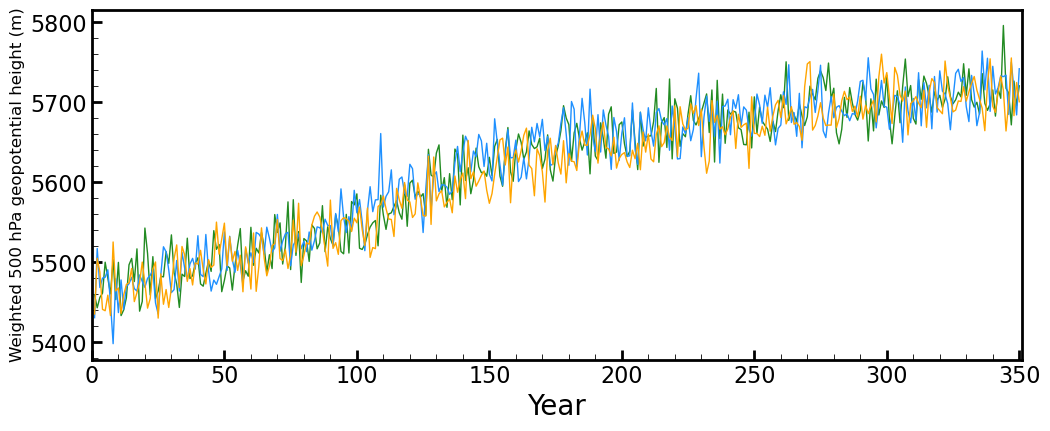

In [32]:
fig = plt.figure(figsize = (12,10))
gs=GridSpec(2,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- SMB --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_Z500_JJA_sel_weighted, color = 'forestgreen', linewidth = 1);
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted, color = 'dodgerblue', linewidth = 1);
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted, color = 'orange', linewidth = 1);

ax1.set_xlim([0, 351])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('Weighted 500 hPa geopotential height (m)', fontsize=size_label-8)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.28)

#### GBI series

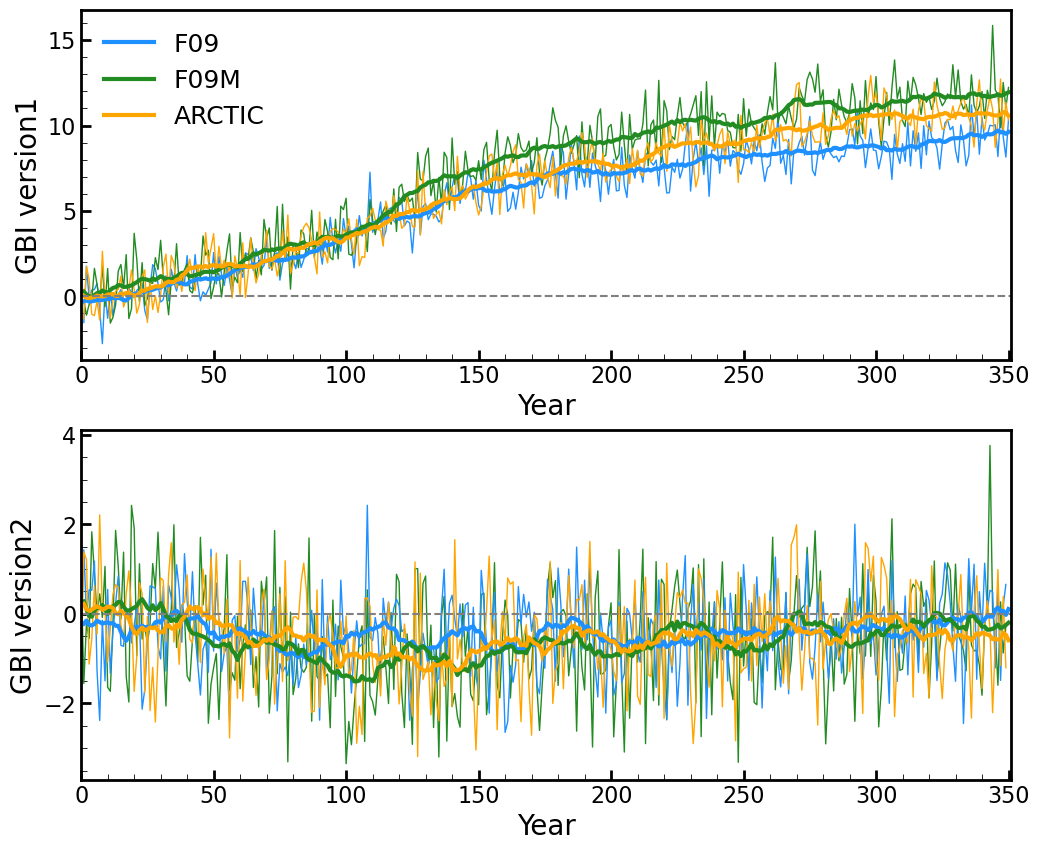

In [33]:
fig = plt.figure(figsize = (12,10))
gs=GridSpec(2,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- version 1 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_GBI1_JJA, color = 'dodgerblue', linewidth = 1);
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_GBI1_JJA, color = 'forestgreen', linewidth = 1);
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_GBI1_JJA, color = 'orange', linewidth = 1);

f09_nohacks_1pctCO2_4xext_GBI1_JJA_rm = f09_nohacks_1pctCO2_4xext_GBI1_JJA.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_GBI1_JJA_rm = f09_1pctCO2_4xext_GBI1_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_GBI1_JJA_rm = ARCTIC_1pctCO2_4xext_GBI1_JJA.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_GBI1_JJA_rm, color = 'dodgerblue', linewidth = 3, label='F09')
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_GBI1_JJA_rm, color = 'forestgreen', linewidth = 3, label='F09M')
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_GBI1_JJA_rm, color = 'orange', linewidth = 3, label='ARCTIC')
plt.axhline(y=0., color='gray', linestyle='--')

ax1.set_xlim([0, 351])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GBI version1', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- version 2 --------------------------------------------
ax2 = plt.subplot(gs[1])

ax2.plot(np.arange(0,350), f09_1pctCO2_4xext_GBI2_JJA, color = 'forestgreen', linewidth = 1);
ax2.plot(np.arange(0,350), f09_nohacks_1pctCO2_4xext_GBI2_JJA, color = 'dodgerblue', linewidth = 1);
ax2.plot(np.arange(0,350), ARCTIC_1pctCO2_4xext_GBI2_JJA, color = 'orange', linewidth = 1);

f09_nohacks_1pctCO2_4xext_GBI2_JJA_rm = f09_nohacks_1pctCO2_4xext_GBI2_JJA.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_GBI2_JJA_rm = f09_1pctCO2_4xext_GBI2_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_GBI2_JJA_rm = ARCTIC_1pctCO2_4xext_GBI2_JJA.rolling(time=20, center=True, min_periods=2).mean()

ax2.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_GBI2_JJA_rm, color = 'dodgerblue', linewidth = 3, label='F09')
ax2.plot(np.arange(1,351), f09_1pctCO2_4xext_GBI2_JJA_rm, color = 'forestgreen', linewidth = 3, label='F09M')
ax2.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_GBI2_JJA_rm, color = 'orange', linewidth = 3, label='ARCTIC')
plt.axhline(y=0., color='gray', linestyle='--')

ax2.set_xlim([0, 351])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('GBI version2', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.28)

## 2. Scatter plot of JJA GBI and melt

### Read data

In [34]:
## BG iteration 7
BG7_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_Z3_JJA_yearly.nc')['Z3'] #geopotential height(asl) [m]
BG7_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PS_JJA_yearly.nc')['PS'] #surface pressure [Pa]
hyam = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hyam'] #hybrid A coefficient at layer midpoints [] 
hybm = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hybm'] #hybrid B coefficient at layer midpoints []
f09_lon = BG7_Z3_JJA_yearly.lon
f09_lat = BG7_Z3_JJA_yearly.lat

In [35]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_Z3_1pctCO2_JJA_yearly.nc')['Z3'][:140,:,:,:]
f09_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PS_1pctCO2_JJA_yearly.nc')['PS'][:140,:,:]

# 4xext
f09_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_Z3_4xext_JJA_yearly.nc')['Z3']
f09_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PS_4xext_JJA_yearly.nc')['PS']

In [36]:
## f09nohacks
# piControl
f09_nohacks_piControl_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_piControl_JJA_yearly.nc')['Z3']
f09_nohacks_piControl_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_piControl_JJA_yearly.nc')['PS']

# 1pctCO2
f09_nohacks_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_1pctCO2_JJA_yearly.nc')['Z3']
f09_nohacks_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_1pctCO2_JJA_yearly.nc')['PS']

# 4xext
f09_nohacks_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_Z3_4xext_JJA_yearly.nc')['Z3']
f09_nohacks_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PS_4xext_JJA_yearly.nc')['PS']

In [37]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_piControl_p4_JJA_yearly.nc')['Z3']
ARCTIC_piControl_p4_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_piControl_p4_JJA_yearly.nc')['PS']

# 1pctCO2
ARCTIC_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_1pctCO2_JJA_yearly.nc')['Z3']
ARCTIC_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_1pctCO2_JJA_yearly.nc')['PS']

# 4xext
ARCTIC_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_Z3_4xext_JJA_yearly.nc')['Z3']
ARCTIC_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PS_4xext_JJA_yearly.nc')['PS']
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']

In [38]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

### Calculate

In [39]:
# Reference period for standardation

# last 80 years of PI before warming
f09_Z3_JJA_PI = BG7_Z3_JJA_yearly[69:149,:,:,:]
f09_PS_JJA_PI = BG7_PS_JJA_yearly[69:149,:,:]

f09_nohacks_Z3_JJA_PI = f09_nohacks_piControl_Z3_JJA_yearly[-80:,:,:,:]
f09_nohacks_PS_JJA_PI = f09_nohacks_piControl_PS_JJA_yearly[-80:,:,:]

ARCTIC_Z3_JJA_PI = ARCTIC_piControl_p4_Z3_JJA_yearly[-80:,:,:]
ARCTIC_PS_JJA_PI = ARCTIC_piControl_p4_PS_JJA_yearly[-80:,:]

In [40]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_1pctCO2_Z3_JJA_yearly, f09_4xext_Z3_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_1pctCO2_PS_JJA_yearly, f09_4xext_PS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Z3_JJA_yearly, f09_nohacks_4xext_Z3_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PS_JJA_yearly, f09_nohacks_4xext_PS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Z3_JJA_yearly, ARCTIC_4xext_Z3_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PS_JJA_yearly, ARCTIC_4xext_PS_JJA_yearly], dim='time')

#### Version 2: 

Area weighted 500 hPa geopotential height over this Greenland region minus that calculated over the entire hemispheric zonal band of 60-80N (Hanna2018,2022, Sellevold2020)

#### Step 1: lat lon box [60-80N, 20-80W]

In [41]:
# Slice the lat lon box [60-80N, 20-80W]
f09_PI_Z3_JJA_sel = f09_Z3_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_PI_PS_JJA_sel = f09_PS_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_nohacks_PI_Z3_JJA_sel = f09_nohacks_Z3_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_nohacks_PI_PS_JJA_sel = f09_nohacks_PS_JJA_PI.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

In [42]:
# Slice the lat lon box [60-80N, 20-80W]
f09_1pctCO2_4xext_Z3_JJA_sel = f09_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_1pctCO2_4xext_PS_JJA_sel = f09_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_nohacks_1pctCO2_4xext_Z3_JJA_sel = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
f09_nohacks_1pctCO2_4xext_PS_JJA_sel = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))

f09_area_lonlat = f09_1pctCO2_4xext_PS_JJA_yearly[0,:,:]*0 + f09_area
f09_area_sel = f09_area_lonlat.sel(lat=slice(60,80)).sel(lon=slice(-80+360,-20+360))
#f09_area_sel.plot();

In [43]:
# For ARCTIC, masked the vars
ARCTIC_PI_Z3_JJA_sel = ARCTIC_Z3_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))
ARCTIC_PI_PS_JJA_sel = ARCTIC_PS_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

In [44]:
# For ARCTIC, masked the vars
ARCTIC_1pctCO2_4xext_Z3_JJA_sel = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))
ARCTIC_1pctCO2_4xext_PS_JJA_sel = ARCTIC_1pctCO2_4xext_PS_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

ARCTIC_area_sel = ARCTIC_1pctCO2_4xext_PS_JJA_sel[0,:]*0 + ARCTIC_area[0,:]
#ARCTIC_area_sel = ARCTIC_area_sel.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

In [15]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_PI_Z500_JJA_sel = f09_PI_PS_JJA_sel*0
f09_nohacks_PI_Z500_JJA_sel = f09_nohacks_PI_PS_JJA_sel*0
ARCTIC_PI_Z500_JJA_sel = ARCTIC_PI_PS_JJA_sel*0

for i in range(80):
    f09_PI_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_PI_Z3_JJA_sel[i,:,:,:], ps=f09_PI_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_PI_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_PI_Z3_JJA_sel[i,:,:,:], ps=f09_nohacks_PI_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_PI_Z500_JJA_sel[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_PI_Z3_JJA_sel[i,:,:], ps=ARCTIC_PI_PS_JJA_sel[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [16]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_1pctCO2_4xext_Z500_JJA_sel = f09_1pctCO2_4xext_PS_JJA_sel*0
f09_nohacks_1pctCO2_4xext_Z500_JJA_sel = f09_nohacks_1pctCO2_4xext_PS_JJA_sel*0
ARCTIC_1pctCO2_4xext_Z500_JJA_sel = ARCTIC_1pctCO2_4xext_PS_JJA_sel*0

for i in range(350):
    f09_1pctCO2_4xext_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_sel[i,:,:,:], ps=f09_1pctCO2_4xext_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_1pctCO2_4xext_Z500_JJA_sel[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_sel[i,:,:,:], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_sel[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_1pctCO2_4xext_Z500_JJA_sel[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_sel[i,:,:], ps=ARCTIC_1pctCO2_4xext_PS_JJA_sel[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [17]:
# Calculate area weighted 500hPa geopotential height
f09_PI_Z500_JJA_sel_weighted = (f09_PI_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
f09_nohacks_PI_Z500_JJA_sel_weighted = (f09_nohacks_PI_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
ARCTIC_PI_Z500_JJA_sel_weighted = (ARCTIC_PI_Z500_JJA_sel * ARCTIC_area_sel).sum(dim=['ncol']) / (ARCTIC_area_sel).sum(dim=['ncol'])

In [18]:
# Calculate area weighted 500hPa geopotential height
f09_1pctCO2_4xext_Z500_JJA_sel_weighted = (f09_1pctCO2_4xext_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted = (f09_nohacks_1pctCO2_4xext_Z500_JJA_sel * f09_area_sel).sum(dim=['lat','lon']) / (f09_area_sel).sum(dim=['lat','lon'])
ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted = (ARCTIC_1pctCO2_4xext_Z500_JJA_sel * ARCTIC_area_sel).sum(dim=['ncol']) / (ARCTIC_area_sel).sum(dim=['ncol'])

#### Step 2: lat band [60-80N]

In [19]:
# Slice the lat band [60-80N]
f09_PI_Z3_JJA_band = f09_Z3_JJA_PI.sel(lat=slice(60,80))
f09_PI_PS_JJA_band = f09_PS_JJA_PI.sel(lat=slice(60,80))

f09_nohacks_PI_Z3_JJA_band = f09_nohacks_Z3_JJA_PI.sel(lat=slice(60,80))
f09_nohacks_PI_PS_JJA_band = f09_nohacks_PS_JJA_PI.sel(lat=slice(60,80))

In [20]:
# Slice the lat band [60-80N]
f09_1pctCO2_4xext_Z3_JJA_band = f09_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80))
f09_1pctCO2_4xext_PS_JJA_band = f09_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80))

f09_nohacks_1pctCO2_4xext_Z3_JJA_band = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly.sel(lat=slice(60,80))
f09_nohacks_1pctCO2_4xext_PS_JJA_band = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly.sel(lat=slice(60,80))

f09_area_lonlat = f09_1pctCO2_4xext_PS_JJA_yearly[0,:,:]*0 + f09_area
f09_area_band = f09_area_lonlat.sel(lat=slice(60,80))

In [21]:
# For ARCTIC, masked the vars
ARCTIC_PI_Z3_JJA_band = ARCTIC_Z3_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))
ARCTIC_PI_PS_JJA_band = ARCTIC_PS_JJA_PI.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))

In [22]:
# For ARCTIC, masked the vars
ARCTIC_1pctCO2_4xext_Z3_JJA_band = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))
ARCTIC_1pctCO2_4xext_PS_JJA_band = ARCTIC_1pctCO2_4xext_PS_JJA_yearly.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80))

ARCTIC_area_band = ARCTIC_1pctCO2_4xext_PS_JJA_band[0,:]*0 + ARCTIC_area[0,:]
#ARCTIC_area_sel = ARCTIC_area_sel.where((ARCTIC_lat>=60)&(ARCTIC_lat<=80)).where((ARCTIC_lon>=280)&(ARCTIC_lon<=340))

In [23]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_PI_Z500_JJA_band = f09_PI_PS_JJA_band*0
f09_nohacks_PI_Z500_JJA_band = f09_nohacks_PI_PS_JJA_band*0
ARCTIC_PI_Z500_JJA_band = ARCTIC_PI_PS_JJA_band*0

for i in range(80):
    f09_PI_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_PI_Z3_JJA_band[i,:,:,:], ps=f09_PI_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_PI_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_PI_Z3_JJA_band[i,:,:,:], ps=f09_nohacks_PI_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_PI_Z500_JJA_band[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_PI_Z3_JJA_band[i,:,:], ps=ARCTIC_PI_PS_JJA_band[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [24]:
## Interpolate to 500hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_1pctCO2_4xext_Z500_JJA_band = f09_1pctCO2_4xext_PS_JJA_band*0
f09_nohacks_1pctCO2_4xext_Z500_JJA_band = f09_nohacks_1pctCO2_4xext_PS_JJA_band*0
ARCTIC_1pctCO2_4xext_Z500_JJA_band = ARCTIC_1pctCO2_4xext_PS_JJA_band*0

for i in range(350):
    f09_1pctCO2_4xext_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_band[i,:,:,:], ps=f09_1pctCO2_4xext_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_1pctCO2_4xext_Z500_JJA_band[i,:,:] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_band[i,:,:,:], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_band[i,:,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_1pctCO2_4xext_Z500_JJA_band[i,:] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_band[i,:,:], ps=ARCTIC_1pctCO2_4xext_PS_JJA_band[i,:], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [25]:
# Calculate area weighted 500hPa geopotential height over the 60-80N band
f09_PI_Z500_JJA_band_weighted = (f09_PI_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
f09_nohacks_PI_Z500_JJA_band_weighted = (f09_nohacks_PI_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
ARCTIC_PI_Z500_JJA_band_weighted = (ARCTIC_PI_Z500_JJA_band * ARCTIC_area_band).sum(dim=['ncol']) / (ARCTIC_area_band).sum(dim=['ncol'])

In [26]:
# Calculate area weighted 500hPa geopotential height over the 60-80N band
f09_1pctCO2_4xext_Z500_JJA_band_weighted = (f09_1pctCO2_4xext_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
f09_nohacks_1pctCO2_4xext_Z500_JJA_band_weighted = (f09_nohacks_1pctCO2_4xext_Z500_JJA_band * f09_area_band).sum(dim=['lat','lon']) / (f09_area_band).sum(dim=['lat','lon'])
ARCTIC_1pctCO2_4xext_Z500_JJA_band_weighted = (ARCTIC_1pctCO2_4xext_Z500_JJA_band * ARCTIC_area_band).sum(dim=['ncol']) / (ARCTIC_area_band).sum(dim=['ncol'])

#### Step 3: Calculate GBI2

In [27]:
# GBI2:
f09_PI_Z500_diff_JJA = f09_PI_Z500_JJA_sel_weighted-f09_PI_Z500_JJA_band_weighted
f09_nohacks_PI_Z500_diff_JJA = f09_nohacks_PI_Z500_JJA_sel_weighted-f09_nohacks_PI_Z500_JJA_band_weighted
ARCTIC_PI_Z500_diff_JJA = ARCTIC_PI_Z500_JJA_sel_weighted-ARCTIC_PI_Z500_JJA_band_weighted

f09_1pctCO2_4xext_Z500_diff_JJA = f09_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_1pctCO2_4xext_Z500_JJA_band_weighted
f09_nohacks_1pctCO2_4xext_Z500_diff_JJA = f09_nohacks_1pctCO2_4xext_Z500_JJA_sel_weighted-f09_nohacks_1pctCO2_4xext_Z500_JJA_band_weighted
ARCTIC_1pctCO2_4xext_Z500_diff_JJA = ARCTIC_1pctCO2_4xext_Z500_JJA_sel_weighted-ARCTIC_1pctCO2_4xext_Z500_JJA_band_weighted

f09_PI_Z500_diff_JJA_mean = f09_PI_Z500_diff_JJA.mean()
f09_PI_Z500_diff_JJA_std = f09_PI_Z500_diff_JJA.std()
f09_nohacks_PI_Z500_diff_JJA_mean = f09_nohacks_PI_Z500_diff_JJA.mean()
f09_nohacks_PI_Z500_diff_JJA_std = f09_nohacks_PI_Z500_diff_JJA.std()
ARCTIC_PI_Z500_diff_JJA_mean = ARCTIC_PI_Z500_diff_JJA.mean()
ARCTIC_PI_Z500_diff_JJA_std = ARCTIC_PI_Z500_diff_JJA.std()

f09_1pctCO2_4xext_GBI2_JJA = (f09_1pctCO2_4xext_Z500_diff_JJA - f09_PI_Z500_diff_JJA_mean)/f09_PI_Z500_diff_JJA_std
f09_nohacks_1pctCO2_4xext_GBI2_JJA = (f09_nohacks_1pctCO2_4xext_Z500_diff_JJA - f09_nohacks_PI_Z500_diff_JJA_mean)/f09_nohacks_PI_Z500_diff_JJA_std
ARCTIC_1pctCO2_4xext_GBI2_JJA = (ARCTIC_1pctCO2_4xext_Z500_diff_JJA - ARCTIC_PI_Z500_diff_JJA_mean)/ARCTIC_PI_Z500_diff_JJA_std

#### Step 4: Get and calculate JJA melt

In [45]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'][:]
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'][:]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:]
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:]

# 4xext
f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'][:]
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'][:]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]

In [46]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140]
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]

# 4xCO2
f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN']
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW']
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']

In [47]:
## Arctic grid
# 1pctCO2
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']

# 4xext
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']

In [48]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

In [49]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

In [50]:
## Concat
f09_nohacks_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_nohacks_1pctCO2_RAIN_yearly, f09_nohacks_4xext_RAIN_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_nohacks_1pctCO2_SNOW_yearly, f09_nohacks_4xext_SNOW_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_nohacks_1pctCO2_QICE_MELT_yearly, f09_nohacks_4xext_QICE_MELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_nohacks_1pctCO2_QSNOMELT_yearly, f09_nohacks_4xext_QSNOMELT_yearly], dim='time')

f09_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_1pctCO2_RAIN_yearly, f09_4xext_RAIN_yearly], dim='time')
f09_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_1pctCO2_SNOW_yearly, f09_4xext_SNOW_yearly], dim='time')
f09_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_1pctCO2_QICE_MELT_yearly, f09_4xext_QICE_MELT_yearly], dim='time')
f09_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_1pctCO2_QSNOMELT_yearly, f09_4xext_QSNOMELT_yearly], dim='time')

ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')

In [51]:
## Calculate total precip and melt
f09_nohacks_1pctCO2_4xext_prec_yearly = f09_nohacks_1pctCO2_4xext_RAIN_yearly + f09_nohacks_1pctCO2_4xext_SNOW_yearly
f09_nohacks_1pctCO2_4xext_melt_yearly = f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly + f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly

f09_1pctCO2_4xext_prec_yearly = f09_1pctCO2_4xext_RAIN_yearly + f09_1pctCO2_4xext_SNOW_yearly
f09_1pctCO2_4xext_melt_yearly = f09_1pctCO2_4xext_QICE_MELT_yearly + f09_1pctCO2_4xext_QSNOMELT_yearly

ARCTIC_1pctCO2_4xext_prec_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly
ARCTIC_1pctCO2_4xext_melt_yearly = ARCTIC_1pctCO2_4xext_QICE_MELT_yearly + ARCTIC_1pctCO2_4xext_QSNOMELT_yearly

In [52]:
## Integrate over the GrIS
f09_nohacks_int_1pctCO2_4xext_prec = (f09_nohacks_1pctCO2_4xext_prec_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_nohacks_int_1pctCO2_4xext_melt = (f09_nohacks_1pctCO2_4xext_melt_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12

f09_int_1pctCO2_4xext_prec = (f09_1pctCO2_4xext_prec_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12
f09_int_1pctCO2_4xext_melt = (f09_1pctCO2_4xext_melt_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])*(3600*24*365)/1e12

ARCTIC_int_1pctCO2_4xext_prec = (ARCTIC_1pctCO2_4xext_prec_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12
ARCTIC_int_1pctCO2_4xext_melt = (ARCTIC_1pctCO2_4xext_melt_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])*(3600*24*365)/1e12

#### Step 5: Lanczos high-pass filter

In [53]:
## Lanczos Filter (non-recursive)
## Apply a very standard non-recursive filter called the Lanczos Filter in the time dimension

# Function to make window for Lanczos Filter
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window in time steps
    cutoff: float
        The cutoff frequency in inverse time steps. 
        (e.g., for data collected every hour, frequency units are per hour)
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k) 
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma    
    return w[1:-1]

# specify the window length for filters
window = 21 ## (default 25) 
cutoff = 1. / 10. ## (default 1./11.)
wgts24 = low_pass_weights(window, cutoff)

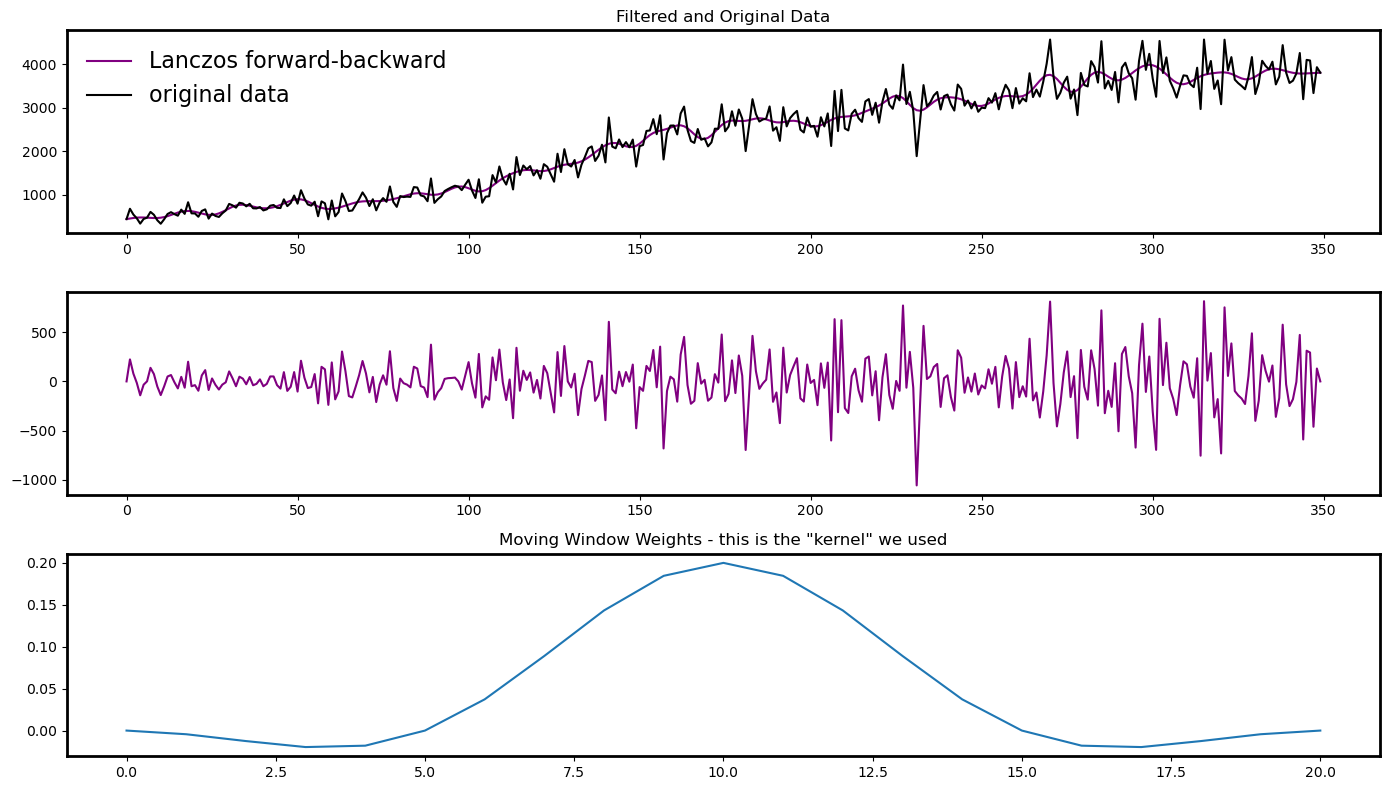

In [54]:
# Melt
f=plt.figure(figsize=(14,8))
gs=GridSpec(3,1)
fig=plt.subplot(gs[0,0])
y1 = sig.filtfilt(wgts24,np.sum(wgts24),ARCTIC_int_1pctCO2_4xext_melt.values)
plt.plot(y1, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(ARCTIC_int_1pctCO2_4xext_melt.values,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data')
plt.legend(frameon = False, fontsize = 16);

fig=plt.subplot(gs[1,0])
plt.plot(ARCTIC_int_1pctCO2_4xext_melt.values-y1, color = 'purple');

fig=plt.subplot(gs[2,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')

f.tight_layout()

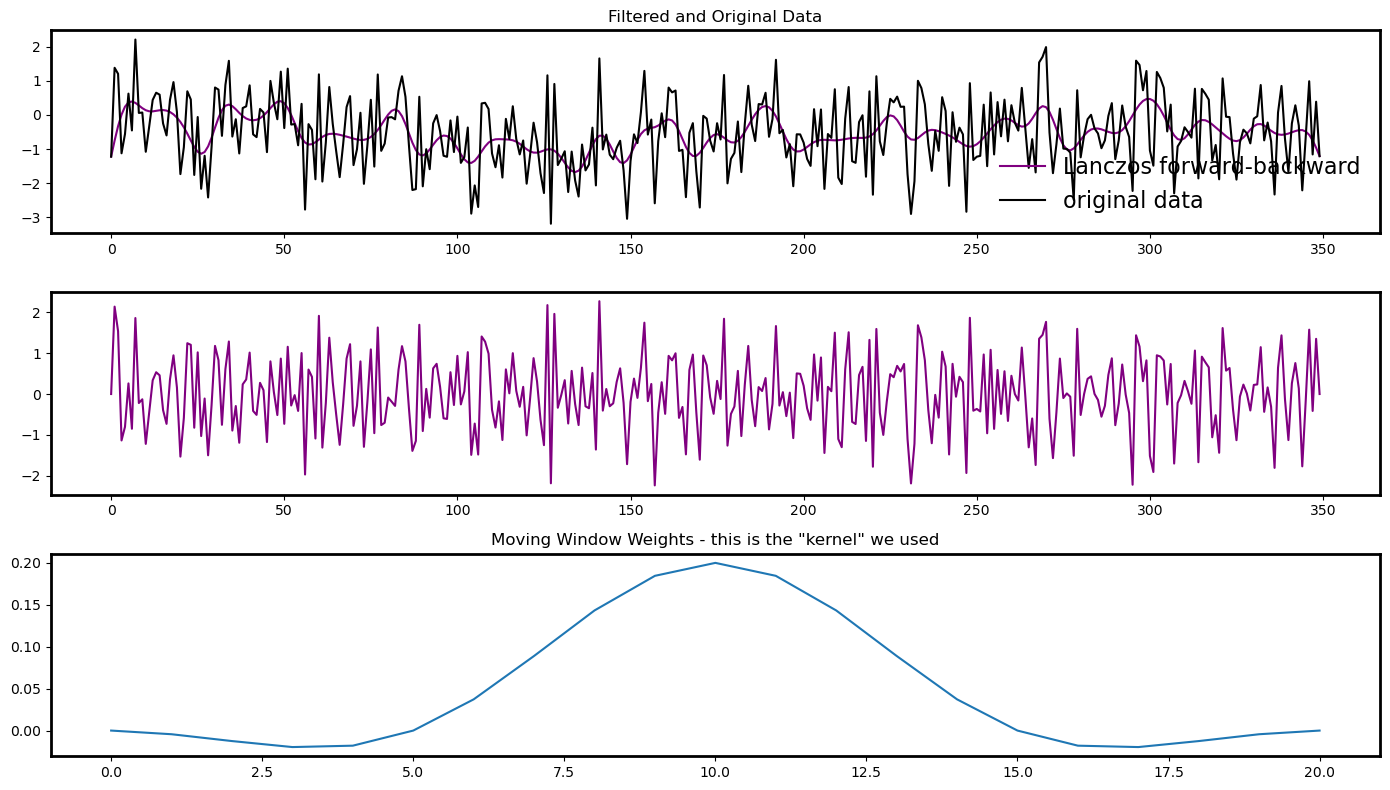

In [55]:
# GBI2
f=plt.figure(figsize=(14,8))
gs=GridSpec(3,1)
fig=plt.subplot(gs[0,0])
y2 = sig.filtfilt(wgts24,np.sum(wgts24),ARCTIC_1pctCO2_4xext_GBI2_JJA.values)
plt.plot(y2, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(ARCTIC_1pctCO2_4xext_GBI2_JJA.values,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data')
plt.legend(frameon = False, fontsize = 16);

fig=plt.subplot(gs[1,0])
plt.plot(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, color = 'purple');

fig=plt.subplot(gs[2,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')

f.tight_layout()

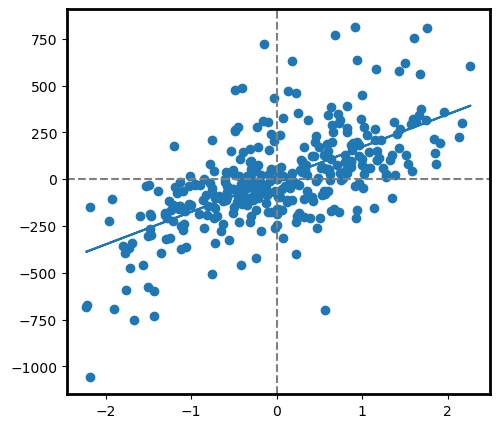

In [56]:
fig = plt.figure(figsize = (12,5))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] =14

slope, intercept, r_value, p_value, std_err = stats.linregress(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, ARCTIC_int_1pctCO2_4xext_melt.values-y1)  

ax1 = plt.subplot(gs[0])

plt.scatter(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, ARCTIC_int_1pctCO2_4xext_melt.values-y1)
plt.plot(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, (ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2)*slope+intercept)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.title('', fontsize='20')

plt.show()

In [57]:
r_value**2

0.3983892496398561

### Plot

In [58]:
## Test if the GBI trend is significant
# year 1-140
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(1,141), ARCTIC_1pctCO2_4xext_GBI2_JJA[:140])
print(p_value) # significant
print(slope)
print('')

# year 141-350
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(141,351), ARCTIC_1pctCO2_4xext_GBI2_JJA[140:])
print(p_value) # not significant

4.493484642039737e-06
-0.009981234403465792

0.12731354806853185


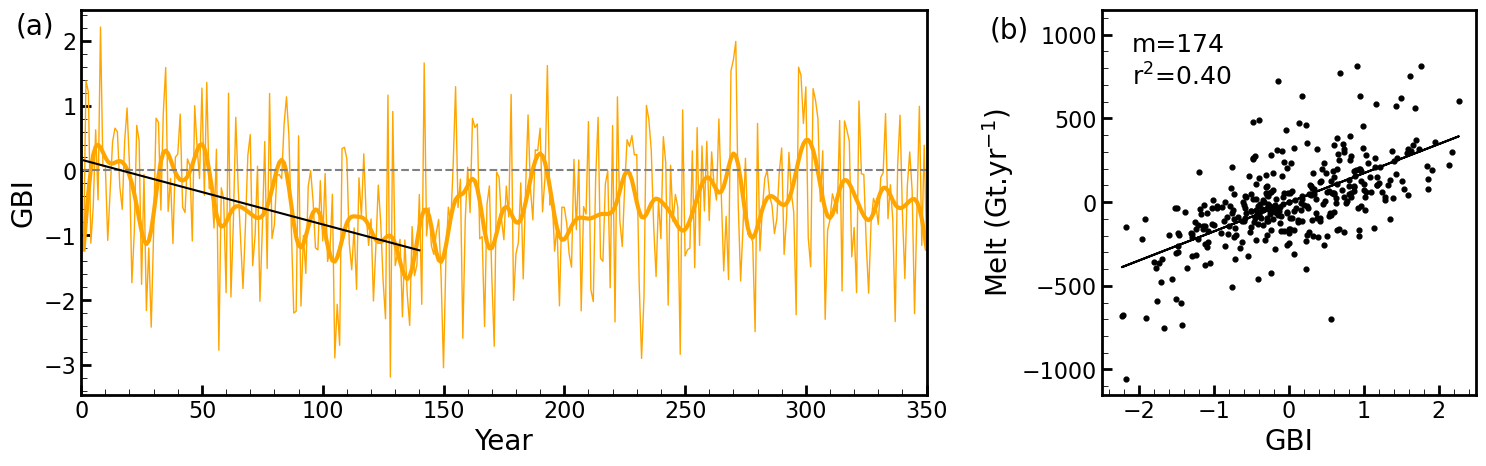

In [59]:
fig = plt.figure(figsize = (18,5))
gs=GridSpec(5,18)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18

#-------------------------------------------- GBI2 --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:11])

ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_GBI2_JJA, color = 'orange', linewidth = 1);
ax1.plot(np.arange(1,351), y2, color = 'orange', linewidth = 3, label='ARCTIC')
ax1.axhline(y=0., color='gray', linestyle='--')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(1,141), ARCTIC_1pctCO2_4xext_GBI2_JJA[:140])
ax1.plot(np.arange(1,141), np.arange(1,141)*slope+intercept, color='k')

ax1.text(-27, 2.1, '(a)', fontsize=size_label)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GBI', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

#-------------------------------------------- version 2 --------------------------------------------
ax2 = plt.subplot(gs[0:5,13:18])

slope, intercept, r_value, p_value, std_err = stats.linregress(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, ARCTIC_int_1pctCO2_4xext_melt.values-y1)  

ax2.scatter(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, ARCTIC_int_1pctCO2_4xext_melt.values-y1, color='k', s=12)
ax2.plot(ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2, (ARCTIC_1pctCO2_4xext_GBI2_JJA.values-y2)*slope+intercept, color='k')

plt.text(-2.1, 900, 'm=174', fontsize=size_text)
plt.text(-2.1, 700, '$\mathregular{r^{2}}$=0.40', fontsize=size_text)
plt.text(-4, 980, '(b)', fontsize=size_label)

ax2.set_xlim([-2.5, 2.5])
ax2.set_ylim([-1150, 1150])
ax2.set_ylabel('Melt (Gt.$\mathregular{yr^{-1}}$)', fontsize=size_label)
ax2.set_xlabel('GBI', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.3)
plt.savefig(home_dir+'dynamic_GrIS/github/plot/tseries_GBI_scatter_GBI_melt.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

In [60]:
print(p_value)
print(r_value**2)
print(slope)

2.689941568959224e-40
0.3983892496398561
173.71805918932628
